# PokerML

In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical

Make sure that you have Vivado suite in your environment.

In [3]:
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configuration

In [5]:
DATA_DIR = "data"

MODELS_DIR = 'models/'
DATA_NPY_DIR = DATA_DIR + '/npy/'

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 52

QKERAS_TRAIN = True ## I did not debug yet the issue with the QKeras saved model

## Load data

In [6]:
X_train_val = np.load(DATA_NPY_DIR + 'X_train_val.npy')
X_test = np.load(DATA_NPY_DIR + 'X_test.npy')
y_train_val = np.load(DATA_NPY_DIR + 'y_train_val.npy')
y_test = np.load(DATA_NPY_DIR + 'y_test.npy')
classes = np.load(DATA_NPY_DIR + 'classes.npy', allow_pickle=True)

In [7]:
print('Train and validation set:', X_train_val.shape[0])
print('Test set:                ', X_test.shape[0])
print('Classes:                 ', classes.shape[0])

Train and validation set: 11980
Test set:                 2996
Classes:                  52


## Train QKeras model

In [12]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from qkeras import QDense, QActivation, QConv2D
from qkeras.quantizers import quantized_bits, quantized_relu

# # ENABLE THIS IF YOU USE PRUNING
# from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
# from tensorflow_model_optimization.sparsity.keras import strip_pruning
# import tensorflow_model_optimization as tfmot

import pickle

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [14]:
CHECKPOINT_FILENAME = MODELS_DIR + 'qkeras/model.h5'

model = Sequential()

model.add(QConv2D(4,
                 kernel_size=(3, 3),
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                 kernel_quantizer=quantized_bits(6, 0, alpha=1),
                 bias_quantizer=quantized_bits(6, 0, alpha=1),
                 kernel_initializer='lecun_uniform',
                 kernel_regularizer=l1(0.0001),
                 name='conv1'))

model.add(QActivation(activation=quantized_relu(6),
                      name='relu1'))

model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool1'))

model.add(Flatten(name='flatten'))

model.add(QDense(NUM_CLASSES,
                 kernel_quantizer=quantized_bits(6, 0, alpha=1),
                 bias_quantizer=quantized_bits(6, 0, alpha=1),
                 kernel_initializer='lecun_uniform',
                 kernel_regularizer=l1(0.0001),
                 activation='softmax',
                 name='output'))

model.summary()

In [15]:
if QKERAS_TRAIN:
    from qkeras.utils import model_save_quantized_weights

    # Using learning rate with exponential decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.001,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )
    adam = Adam(learning_rate=lr_schedule)
    
    #adam = Adam(learning_rate=0.001)

    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

    # A few other callbacks. These should not give warnings on deprecated features.
    callbacks = [
            ModelCheckpoint(
                CHECKPOINT_FILENAME,
                monitor='val_loss',
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                save_freq='epoch')
       #,
       #pruning_callbacks.UpdatePruningStep()
       #,#ReduceLROnPlateau(patience=75, min_delta=1**-6), 
    ]

    history = model.fit(
        X_train_val,
        y_train_val,
        batch_size=128,
        epochs=20,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks
    )
    
# # Strip the model of pruning information
#     model = strip_pruning(model)
#    model.save(CHECKPOINT_FILENAME)

    # Use this instead if you use the callbacks
    history_file = CHECKPOINT_FILENAME.replace('.h5', '-history.pkl')
    with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    print(f'Saving history to: {history_file}')
    print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')


else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)

Epoch 1/20
71/71 [==============================] - 8s 89ms/step - loss: 3.8744 - accuracy: 0.1765 - val_loss: 3.0159 - val_accuracy: 0.4497
Epoch 2/20
71/71 [==============================] - 5s 77ms/step - loss: 2.3764 - accuracy: 0.6070 - val_loss: 1.8558 - val_accuracy: 0.7202
Epoch 3/20
71/71 [==============================] - 5s 74ms/step - loss: 1.4471 - accuracy: 0.8435 - val_loss: 1.2166 - val_accuracy: 0.8845
Epoch 4/20
71/71 [==============================] - 5s 75ms/step - loss: 1.0032 - accuracy: 0.9327 - val_loss: 0.9151 - val_accuracy: 0.9616
Epoch 5/20
71/71 [==============================] - 5s 76ms/step - loss: 0.8038 - accuracy: 0.9735 - val_loss: 0.7697 - val_accuracy: 0.9796
Epoch 6/20
71/71 [==============================] - 5s 74ms/step - loss: 0.6928 - accuracy: 0.9861 - val_loss: 0.6849 - val_accuracy: 0.9876
Epoch 7/20
71/71 [==============================] - 5s 77ms/step - loss: 0.6228 - accuracy: 0.9933 - val_loss: 0.6278 - val_accuracy: 0.9903
Epoch 8/20
71

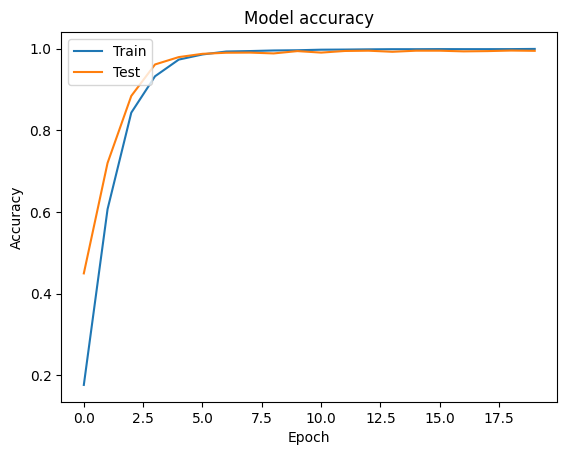

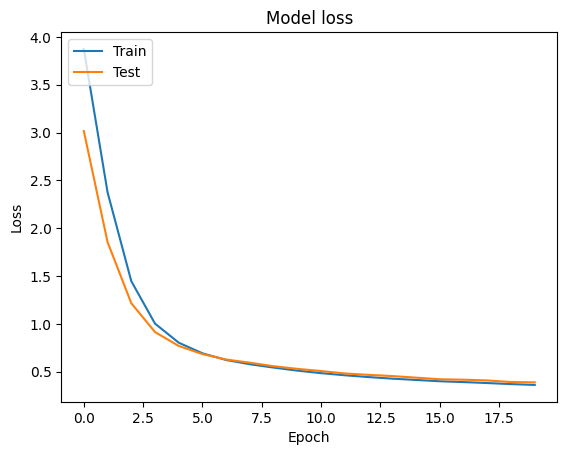

In [16]:
if QKERAS_TRAIN:
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [17]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))

print("QKeras accuracy: {:.6f}%".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))

94/94 [==============================] - 1s 11ms/step
QKeras accuracy: 99.532710%


Pre trained model sul have accuracy = 98.030708%

## QKeras to hls4ml (Quantization Aware Training)

In [ ]:
import hls4ml
import plotting

# First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['Model']['ReuseFactor'] = 128

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource'
# or increase the reuse factor individually for large layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 200
    hls_config['LayerName'][Layer]['Trace'] = True

hls_config['LayerName']['output']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='VivadoAccelerator')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'projects/qat_hls4ml_prj'
#cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'

hls_model = hls4ml.converters.keras_to_hls(cfg)

In [ ]:
hls_model.compile()

In [ ]:
# IF PREDICTION TAKE TOO MUCH PLEASE
# REDUCE THE NUMBER OF INPUTS
print(X_test.shape)
print(X_test[:10].shape)

In [ ]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

In [ ]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#print("Accuracy baseline:  {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy quantized: {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml:    {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

```
With pretrained model you should expect:
Accuracy quantized: 0.980307%
Accuracy hls4ml:    0.979973%
```

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Args:
        cm (array, shape = [n, n]): Confusion matrix
        class_names (array, shape = [n]): Array of class names
    """
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_test_ = np.argmax(y_test, axis=1)
y_qkeras_ = np.argmax(y_qkeras, axis=1)

cm = confusion_matrix(y_test_, y_qkeras_)

plot_confusion_matrix(cm, classes)

In [ ]:
hls_model.build(
    csim=False,
    synth=False,
    cosim=False,
    export=False,
    vsynth=False,
)

In [ ]:
hls4ml.report.read_vivado_report('projects/qat_hls4ml_prj')